In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sensitivity_specificity_scatter(csv_path, metric="icbhi_score", figsize=(8,6), save_path=None):
    """
    Plot a sensitivity vs specificity scatter per device and per site.

    Parameters
    ----------
    csv_path : str
        Path to your 'group_performance_summary_foldX.csv'
    metric : str
        Metric to use for color (e.g., 'icbhi_score' or 'f1_macro')
    figsize : tuple
        Size of the matplotlib figure
    save_path : str or None
        Optional path to save the figure (PNG)
    """
    df = pd.read_csv(csv_path, index_col=0)
    df = df.reset_index().rename(columns={"index": "group"})

    # Split type (device/site)
    df["type"] = df["group"].apply(lambda x: "Device" if x.startswith("device") else "Site")
    df["name"] = df["group"].apply(lambda x: x.split("::")[1])

    # Sanity filter
    df = df.dropna(subset=["sensitivity", "specificity", metric])

    # Plot setup
    sns.set(style="whitegrid", context="talk")
    fig, ax = plt.subplots(figsize=figsize)

    # Scatter points
    sns.scatterplot(
        data=df, x="specificity", y="sensitivity",
        hue=metric, style="type", s=200, edgecolor="black", palette="coolwarm", ax=ax
    )

    # Annotate with device/site names
    for _, row in df.iterrows():
        ax.text(row["specificity"] + 0.002, row["sensitivity"] + 0.002,
                row["name"], fontsize=10, weight="bold")

    # Reference lines (mean Sp, Se)
    ax.axvline(df["specificity"].mean(), color="gray", ls="--", lw=1)
    ax.axhline(df["sensitivity"].mean(), color="gray", ls="--", lw=1)

    ax.set_xlim(0.6, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("Specificity (True Negative Rate)")
    ax.set_ylabel("Sensitivity (True Positive Rate)")
    ax.set_title("Domain Bias Analysis: Sensitivity vs Specificity per Device/Site")

    # Legend & layout
    plt.legend(title=metric, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved figure to: {save_path}")

    plt.show()


Each point = one device or site:

X-axis: Specificity → right = fewer false positives.

Y-axis: Sensitivity → up = better detection of abnormalities.

Color: ICBHI (HS) or F1-macro score.

Marker style: circles for devices, triangles for sites.

Dashed lines: average Sp and Se (visualize bias region).

How to read it

Top-right quadrant: balanced & robust domain (ideal).

Bottom-right: conservative (few false positives, misses many positives).

Top-left: noisy (detects everything, but poor precision).

Bottom-left: failure zone (poor both ways).

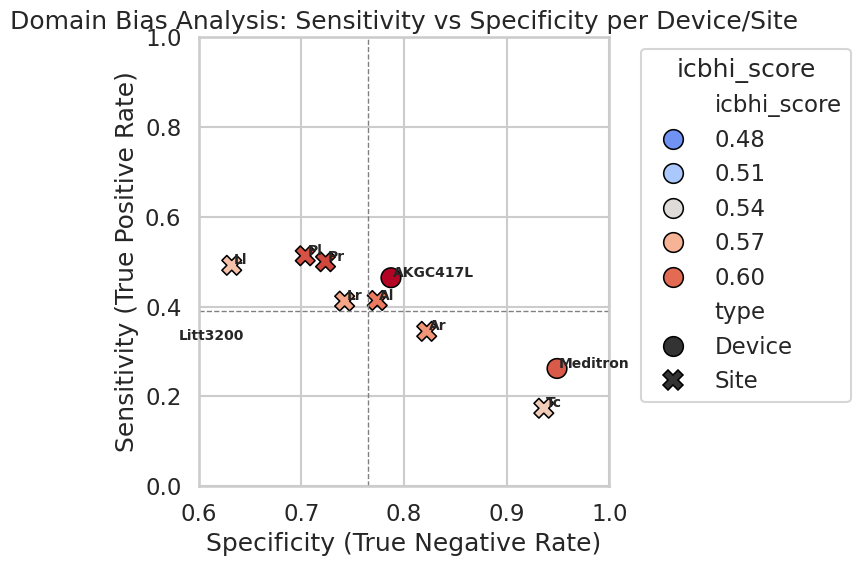

In [4]:
plot_sensitivity_specificity_scatter(
    "../summaries/group_performance_summary_fold0.csv",
    metric="icbhi_score",
    # save_path="figures/sp_vs_se_per_group.png"
)

In [6]:
import numpy as np

def compute_multilabel_metrics(all_labels, all_preds, all_probs=None, verbose=True):
    """
    Compute detailed multi-label metrics + official ICBHI metrics +
    macro-averaged metrics + binary Normal-vs-Abnormal ICBHI score.

    Works for multilabel setup with two binary labels [crackle, wheeze],
    forming 4 composite classes (Normal, Crackle, Wheeze, Both).
    """

    metrics = {}

    # === Composite 4-class masks (true/pred) ===
    is_n = (all_labels[:,0]==0) & (all_labels[:,1]==0)
    is_c = (all_labels[:,0]==1) & (all_labels[:,1]==0)
    is_w = (all_labels[:,0]==0) & (all_labels[:,1]==1)
    is_b = (all_labels[:,0]==1) & (all_labels[:,1]==1)

    pr_n = (all_preds[:,0]==0) & (all_preds[:,1]==0)
    pr_c = (all_preds[:,0]==1) & (all_preds[:,1]==0)
    pr_w = (all_preds[:,0]==0) & (all_preds[:,1]==1)
    pr_b = (all_preds[:,0]==1) & (all_preds[:,1]==1)

    # === Class-wise totals ===
    Nn, Nc, Nw, Nb = is_n.sum(), is_c.sum(), is_w.sum(), is_b.sum()
    Pn = np.sum(is_n & pr_n)
    Pc = np.sum(is_c & pr_c)
    Pw = np.sum(is_w & pr_w)
    Pb = np.sum(is_b & pr_b)

    # === Official 4-class ICBHI metrics ===
    sp = Pn / (Nn + 1e-12)
    se = (Pc + Pw + Pb) / (Nc + Nw + Nb + 1e-12)
    hs = 0.5 * (sp + se)
    metrics.update({'icbhi_specificity': sp, 'icbhi_sensitivity': se, 'icbhi_score': hs})

    if verbose:
        print(f"[ICBHI 4-class] SPE={sp*100:.2f}% | SEN={se*100:.2f}% | HS={hs*100:.2f}%")

    # === Per-class metrics ===
    pattern_names = ['Normal', 'Crackle', 'Wheeze', 'Both']
    is_true = [is_n, is_c, is_w, is_b]
    is_pred = [pr_n, pr_c, pr_w, pr_b]
    Ps = [Pn, Pc, Pw, Pb]
    Ns = [Nn, Nc, Nw, Nb]

    total_samples = len(all_labels)
    per_class = []

    for name, tmask, pmask, P, N in zip(pattern_names, is_true, is_pred, Ps, Ns):
        TP = P
        FN = N - P
        FP = np.sum(~tmask & pmask)
        TN = total_samples - TP - FP - FN

        precision = TP / (TP + FP + 1e-12)
        recall = TP / (TP + FN + 1e-12)         # sensitivity
        specificity = TN / (TN + FP + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        # accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-12)

        per_class.append({
            'name': name,
            'precision': precision,
            'sensitivity': recall,
            'specificity': specificity,
            'f1': f1,
            'support': N
        })

        metrics.update({
            f'{name}_precision': precision,
            f'{name}_sensitivity': recall,
            f'{name}_specificity': specificity,
            f'{name}_f1': f1,
        })

        if verbose:
            print(f"[{name}] P={precision*100:.2f}% | R={recall*100:.2f}% | "
                  f"Sp={specificity*100:.2f}% | F1={f1*100:.2f}%")

    # === Macro and Weighted averages ===
    precisions = [c['precision'] for c in per_class]
    sensitivities = [c['sensitivity'] for c in per_class]
    specificities = [c['specificity'] for c in per_class]
    f1s = [c['f1'] for c in per_class]
    supports = [c['support'] for c in per_class]

    metrics.update({
        'macro_precision': np.mean(precisions),
        'macro_sensitivity': np.mean(sensitivities),
        'macro_specificity': np.mean(specificities),
        'macro_f1': np.mean(f1s),
        'weighted_precision': np.average(precisions, weights=supports),
        'weighted_sensitivity': np.average(sensitivities, weights=supports),
        'weighted_specificity': np.average(specificities, weights=supports),
        'weighted_f1': np.average(f1s, weights=supports),
    })

    if verbose:
        print("\n[Macro averages]")
        print(f"P={metrics['macro_precision']*100:.2f}% | R={metrics['macro_sensitivity']*100:.2f}% | "
              f"Sp={metrics['macro_specificity']*100:.2f}% | F1={metrics['macro_f1']*100:.2f}%")

    # === Binary Normal vs Abnormal (ICBHI style) ===
    is_abn_true = ~is_n
    is_abn_pred = ~pr_n

    TP = np.sum(is_abn_true & is_abn_pred)  # correctly abnormal
    TN = np.sum(is_n & pr_n)                # correctly normal
    FP = np.sum(~is_abn_true & is_abn_pred) # predicted abnormal but actually normal
    FN = np.sum(is_abn_true & ~is_abn_pred) # predicted normal but actually abnormal

    binary_spe = TN / (TN + FP + 1e-12)
    binary_sen = TP / (TP + FN + 1e-12)
    binary_hs = 0.5 * (binary_spe + binary_sen)

    metrics.update({
        'binary_specificity': binary_spe,
        'binary_sensitivity': binary_sen,
        'binary_icbhi_score': binary_hs
    })

    if verbose:
        print("\n[Binary Normal-vs-Abnormal ICBHI]")
        print(f"SPE={binary_spe*100:.2f}% | SEN={binary_sen*100:.2f}% | HS={binary_hs*100:.2f}%")

    return metrics


In [7]:
all_labels = np.array([
    [0,0],  # Normal
    [1,0],  # Crackle
    [0,1],  # Wheeze
    [1,1],  # Both
    [0,0],  # Normal
    [1,0],  # Crackle
])
all_preds = np.array([
    [0,0],  # Normal
    [1,0],  # Crackle
    [0,1],  # Wheeze
    [1,0],  # Crackle
    [1,0],  # Crackle
    [1,1],  # Both
])


m = compute_multilabel_metrics(all_labels, all_preds, verbose=True)
print("\nSummary:", {k: round(v, 3) for k, v in m.items() if "f1" in k})

[ICBHI 4-class] SPE=50.00% | SEN=50.00% | HS=50.00%
[Normal] P=100.00% | R=50.00% | Sp=100.00% | F1=66.67%
[Crackle] P=33.33% | R=50.00% | Sp=50.00% | F1=40.00%
[Wheeze] P=100.00% | R=100.00% | Sp=100.00% | F1=100.00%
[Both] P=0.00% | R=0.00% | Sp=80.00% | F1=0.00%

[Macro averages]
P=58.33% | R=50.00% | Sp=82.50% | F1=51.67%

[Binary Normal-vs-Abnormal ICBHI]
SPE=50.00% | SEN=100.00% | HS=75.00%

Summary: {'Normal_f1': np.float64(0.667), 'Crackle_f1': np.float64(0.4), 'Wheeze_f1': np.float64(1.0), 'Both_f1': np.float64(0.0), 'macro_f1': np.float64(0.517), 'weighted_f1': np.float64(0.522)}


In [8]:
def compute_multilabel_metrics2(all_labels, all_preds, all_probs, verbose=True):
    """
    Compute detailed multi-label metrics + official ICBHI metrics.
    Now includes Sensitivity/Specificity for Normal and Both composite classes.
    """
    metrics = {}

    # === Composite 4-class masks ===
    is_n = (all_labels[:,0]==0) & (all_labels[:,1]==0)
    is_c = (all_labels[:,0]==1) & (all_labels[:,1]==0)
    is_w = (all_labels[:,0]==0) & (all_labels[:,1]==1)
    is_b = (all_labels[:,0]==1) & (all_labels[:,1]==1)

    pr_n = (all_preds[:,0]==0) & (all_preds[:,1]==0)
    pr_c = (all_preds[:,0]==1) & (all_preds[:,1]==0)
    pr_w = (all_preds[:,0]==0) & (all_preds[:,1]==1)
    pr_b = (all_preds[:,0]==1) & (all_preds[:,1]==1)

    # === Counts ===
    Nn, Nc, Nw, Nb = is_n.sum(), is_c.sum(), is_w.sum(), is_b.sum()
    Pn = np.sum(is_n & pr_n)
    Pc = np.sum(is_c & pr_c)
    Pw = np.sum(is_w & pr_w)
    Pb = np.sum(is_b & pr_b)

    # === Per-pattern metrics (Normal, Crackle, Wheeze, Both) ===
    pattern_names = ['Normal', 'Crackle', 'Wheeze', 'Both']
    is_true = [is_n, is_c, is_w, is_b]
    is_pred = [pr_n, pr_c, pr_w, pr_b]

    for name, tmask, pmask in zip(pattern_names, is_true, is_pred):
        tp = np.sum(tmask & pmask)
        fp = np.sum(~tmask & pmask)
        fn = np.sum(tmask & ~pmask)
        tn = np.sum(~tmask & ~pmask)

        precision = tp / (tp + fp + 1e-12)
        recall = tp / (tp + fn + 1e-12)
        f1 = 2 * precision * recall / (precision + recall + 1e-12)
        # acc = (tp + tn) / (tp + tn + fp + fn + 1e-12)
        # sensitivity_c = recall  # TP / (TP+FN)
        specificity_c = tn / (tn + fp + 1e-12)

        print(f"[{name}] P={precision*100:.2f}% | R={recall*100:.2f}% | "
              f"Sp={specificity_c*100:.2f}% | F1={f1*100:.2f}%")

In [9]:
compute_multilabel_metrics(all_labels, all_preds, None, verbose=True)

[ICBHI 4-class] SPE=50.00% | SEN=50.00% | HS=50.00%
[Normal] P=100.00% | R=50.00% | Sp=100.00% | F1=66.67%
[Crackle] P=33.33% | R=50.00% | Sp=50.00% | F1=40.00%
[Wheeze] P=100.00% | R=100.00% | Sp=100.00% | F1=100.00%
[Both] P=0.00% | R=0.00% | Sp=80.00% | F1=0.00%

[Macro averages]
P=58.33% | R=50.00% | Sp=82.50% | F1=51.67%

[Binary Normal-vs-Abnormal ICBHI]
SPE=50.00% | SEN=100.00% | HS=75.00%


{'icbhi_specificity': np.float64(0.49999999999975),
 'icbhi_sensitivity': np.float64(0.499999999999875),
 'icbhi_score': np.float64(0.4999999999998125),
 'Normal_precision': np.float64(0.9999999999989999),
 'Normal_sensitivity': np.float64(0.49999999999975),
 'Normal_specificity': np.float64(0.99999999999975),
 'Normal_f1': np.float64(0.6666666666657777),
 'Crackle_precision': np.float64(0.33333333333322224),
 'Crackle_sensitivity': np.float64(0.49999999999975),
 'Crackle_specificity': np.float64(0.499999999999875),
 'Crackle_f1': np.float64(0.39999999999936),
 'Wheeze_precision': np.float64(0.9999999999989999),
 'Wheeze_sensitivity': np.float64(0.9999999999989999),
 'Wheeze_specificity': np.float64(0.9999999999997999),
 'Wheeze_f1': np.float64(0.9999999999984999),
 'Both_precision': np.float64(0.0),
 'Both_sensitivity': np.float64(0.0),
 'Both_specificity': np.float64(0.79999999999984),
 'Both_f1': np.float64(0.0),
 'macro_precision': np.float64(0.5833333333328055),
 'macro_sensitivit